
   
# Casus: Systeemanalyse
*Auteur: S.A. Klop*
    
In dit notebook wordt behandelt hoe met behulp van tijdreeksanalyse een hydrologische systeem kan worden geanalyseerd. Hierbij wordt gekeken naar een netwerk van meerdere peilbuizen. Door het opstellen en analyseren van tijdreeksmodellen voor al deze peilbuizen kan informatie over het systeem worden verkregen.

**Inhoudsopgave**

- [Verlaging natuurgebied](#Verlaging-natuurgebied)
    - [Beschikbare data](#Beschikbare-data)
    - [Opstellen van het tijdreeksmodel](#Opstellen-van-het-tijdreeksmodel)
    - [Verlaging ten gevolge van onttrekking](#Verlaging-ten-gevolge-van-onttrekking)
   

In [1]:
# inladen van de benodigde python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

import pastas as ps

%matplotlib inline
ps.set_log_level("ERROR")

## Verlaging natuurgebied
In de omgeving een natuurgebied bevindt zich een onttrekking voor een groot industrieel complex. Bij het waterschap is het vermoeden dat deze onttrekking mogelijk leid tot een verlaging van de stijghoogte in het gebied, terwijl dit op basis van de vergunning niet toegestaan is. Het waterschap besluit daarom te kijken of op basis van peilgegevens kan worden aangetoond of de onttrekking voor verlagingen van de stijghoogte heeft gezorgd. Dit wordt onderzocht met behulp van tijdreeksanalyse.

De onttrekking bevindt zich op een afstand van 500 m van het natuurgebied. Hierbij wordt onttrokken uit het eerste watervoerende pakket. Dit is ook het pakket waarin de peilbuizen zich bevinden.

## Beschikbare data
Rondom de onttrekking heeft het waterschap peilbuisgegevens beschikbaar van de peilbuizen PB1, PB2 en PB3. Deze peilbuizen hebben relatief lange meetreeksen met elke een eigen start en eind periode. Helaas meten geen van deze peilbuizen de stijghoogte meer in de afgelopen jaren. In de onderstaande afbeeldingen zijn de meetreeksen van de peilbuizen weergeven. 

De afstanden van de peilbuizen tot aan de onttrekking zijn bepaald. Deze zijn te zien in de onderstaande tabel.

| Peilbuis      | Afstand  [m]  | 
| ------------- |:-------------:| 
| PB1           | 112           | 
| PB2           | 180           | 
| PB3           | 321           |

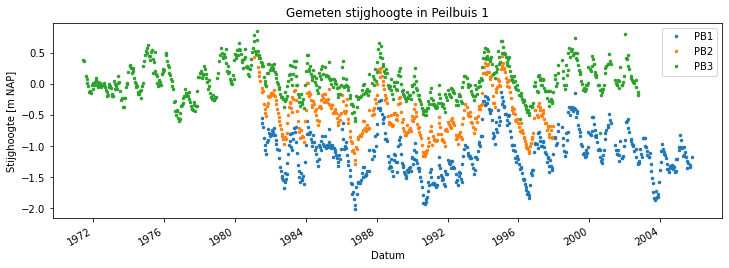

In [2]:
PB1 = pd.read_csv("data/PB1_c.csv", parse_dates=True, index_col="date", squeeze=True)
PB2 = pd.read_csv("data/PB2_c.csv", parse_dates=True, index_col="date", squeeze=True)
PB3 = pd.read_csv("data/PB3_c.csv", parse_dates=True, index_col="date", squeeze=True)

PB1.name = "PB1"
PB2.name = "PB2"
PB3.name = "PB3"

# plotten van de stijghoogtes
fig, ax = plt.subplots(1, 1, figsize=(12,4))
PB1.plot(ax=ax, ls='', marker='.', markersize=5)
PB2.plot(ax=ax, ls='', marker='.', markersize=5)
PB3.plot(ax=ax, ls='', marker='.', markersize=5)

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in Peilbuis 1')
ax.legend();

Om een tijdreeksmodel op te stellen voor stijghoogtemeetreeks wordt gebruik gemaakt van de neerslag en verdamping. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. Voor alle peilbuizen is dit weerstation het dichtsbijzijnde.


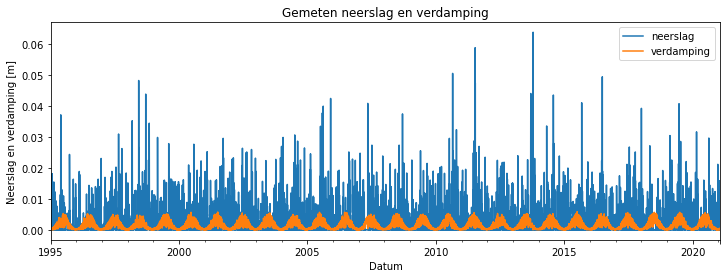

In [3]:
verdamping = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series 
neerslag = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series 

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);
ax.set_xlim(xmin='1995');

Om uit te zoeken wat het effect is van de onttrekking op de gemeten stijghoogte is bij de eigenaar van de onttrekking de meetreeks voor de onttrekking opgehaald. De onttrekking is opgestart in de jaren 60. De onttrekking variert door de jaren heen en is sinds 2010 iets afgebouwd.

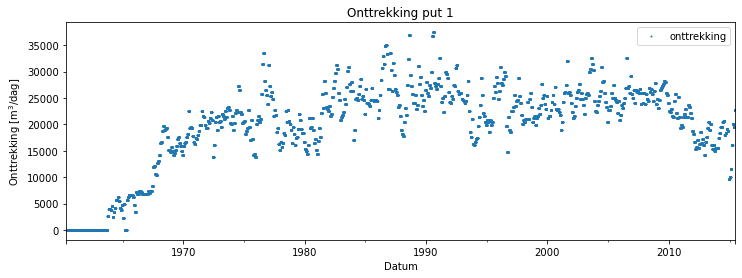

In [4]:
well = pd.read_csv("data/well.csv", index_col=0, parse_dates=True, squeeze=True)

# plotten van de onttrekking
fig, ax = plt.subplots(1, 1, figsize=(12,4))
well.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Onttrekking [m$^3$/dag]')
ax.set_xlabel('Datum')
ax.set_title('Onttrekking put 1')
ax.legend([f'onttrekking']);

### Opstellen van het tijdreeksmodel

Er wordt een model opgesteld voor de stijghoogte observaties, voor elke peilbuis wordt een appart model opgezet. Hierbij wordt de volledige reeks gebruikt voor alle peilbuizen. In de reeksen zijn geen uitschieters gevonden, er is daarom geen reden om de meetreeksen voor te bewerken.

De neerslag en verdamping worden gebruikt als verklarende reeksen. Voor de verklarende reeksen wordt een respons gekozen. De respons functie beschrijft de reactie van de stijghoogte op een externe invloed. Voor het tijdreeksmodellen wordt gekozen voor de Gamma respons functie voor de neerslag en verdamping. Voor elk tijdreeksmodel wordt deze respons functie individueel geoptimaliseerd.

In het tijdreeksmodel wordt gekozen om dezelfde response functie te gebruiken voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule $ R = P - f \cdot E$, waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd. 

Daarnaast wordt ook de onttrekking als verklarende reeks gebruikt. Voor deze verklarende reeks wordt de Hantush responsfunctie gekozen. Naast de verklarende reeksen wordt ook de constante (in het tijdreeksmodel d) geoptimaliseerd in het model.

Met deze verklarende reeksen en de gekozen responsfuncties worden de tijdreeksmodellen geoptimaliseerd. 


In [5]:
# opzetten model
ml = ps.Model(PB1)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush, name='onttrekking',
                    settings='well', up=False)
ml.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie1 = ml.simulate()

Het tijdreeksmodel voor PB1 heeft een R$^2$ van 0.93. Met het tijdreeksmodel kan de gemeten stijghoogte goed worden gesimuleerd. De simulatie van het tijdreeksmodel voor PB1 is te zien in de onstaande afbeelding. Hier is het effect van elke invoerreeks te zien als apparte bijdrage. Hierbij is te zien dat ten gevolge van de onttrekking de stijghoogte wordt verlaagt tussen de circa -2.5 en -1.5 m.

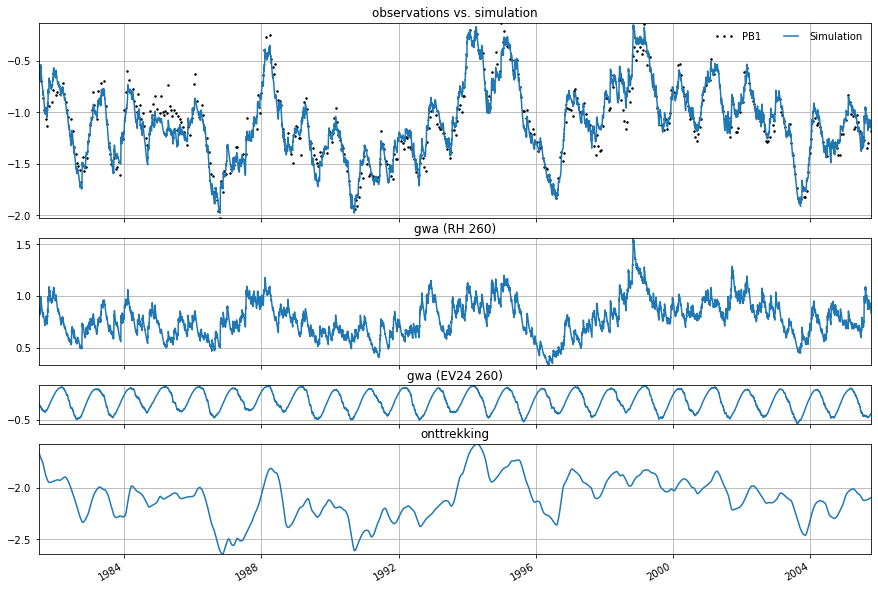

In [6]:
ml.plots.decomposition(figsize=(12,8));

Voor peilbuis PB2 is een tijdreeksmodel opgezet met dezelfde verklarende reeksen. 

In [7]:
# opzetten model
ml2 = ps.Model(PB2)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush, name='onttrekking',
                    settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml2.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie2 = ml2.simulate()


Te zien is dat het tijdreeksmodel een R$^2$ heeft van 0.91. In de onderstaande afbeelding is de simulatie van de stijghoogte weergeven. Daarnaast is per invloed de bijdrage te zien. Hierbij is te zien dat ten gevolge van de onttrekking de stijghoogte wordt verlaagt tussen de circa -1 en -2 m. Dit is lager dan de verlaging die bepaald is ter plaatse van PB1. Dit komt overeen met de hydrologische verwachting, PB2 staat immers verder van de onttrekking dan PB1.

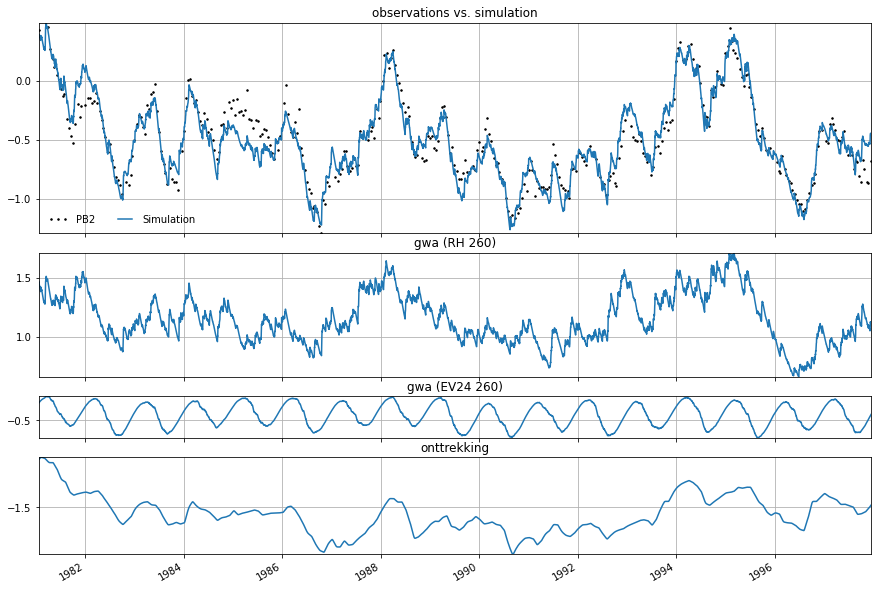

In [8]:
ml2.plots.decomposition(figsize=(12,8));

Als laatste is ook voor peilbuis PB3 een tijdreeksmodel opgesteld.

In [9]:
# opzetten model
ml3 = ps.Model(PB3)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush, name='onttrekking',
                    settings='well', up=False)
ml3.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml3.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie3 = ml3.simulate()

Het tijdreeksmodel heeft een R$^2$ van 0.84, in de onderstaande afbeelding is de gesimuleerde reeks te zien. Per invloed is de bijdrage weergeven. Hier is het effect van elke invoerreeks te zien volgens de modellering. Hierbij is te zien dat de verlaging ten gevolge van de onttrekking tussen de circa -0.5 en -1 m is. Op deze afstand is dus nog steeds een effect van de onttrekking te zien in de stijghoogtemeetreeks.

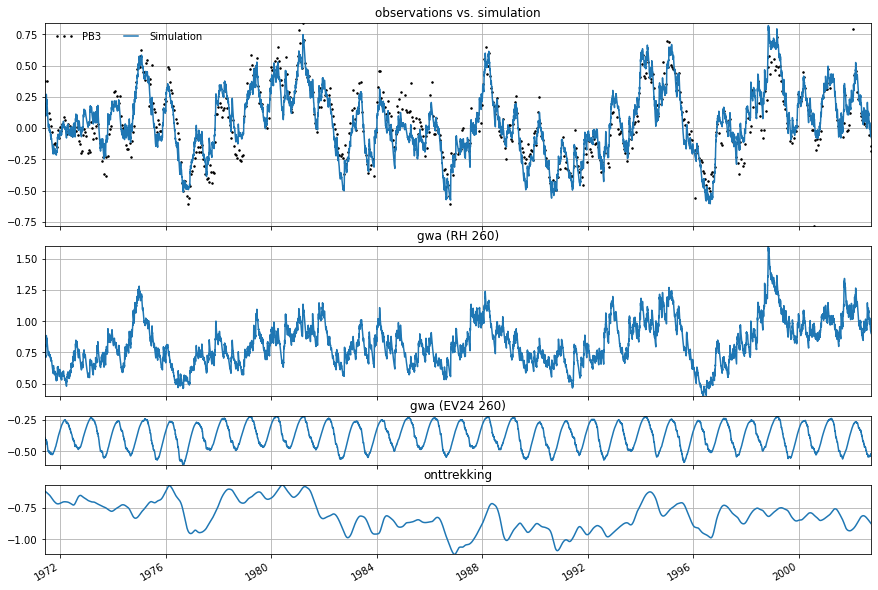

In [10]:
ml3.plots.decomposition(figsize=(12,8));

## Verlaging ten gevolge van onttrekking
In de onderstaande tabel zijn de gemiddelde verlagingen opgenomen zoals deze met de tijdreeksanalyse zijn bepaald. Omdat de meetreeksen van de peilbuizen verschillende meetperiodes hebben wordt gekeken naar de gemiddelde onttrekking voor deze periode en wordt de gemiddelde verlaging per 10.000 m3/d bepaald. 


| Peilbuis      | Afstand  [m]  | Gemiddelde verlaging  [m]  | Gemiddelde onttrekking [m3/d]| Gemiddelde verlaging per 10.000 m3/d  [m]  |
| ------------- |:-------------:|:-------------:| :-------------:| :-------------: |
| PB1           | 112           | -2.12         | 24985 | -0.85 |
| PB2           | 180           | -1.57         | 25129 | -0.63 |
| PB3           | 321           | -0.81       | 23448 | -0.35 |

In de onderstaande grafiek zijn de gemiddeld bepaalde verlagingen per 10.000 m3/d uitgezet tegen de afstand tot de onttrekkingsput. Het watervoerendpakket in de omgeving is uniform, daarom is de verwachting dat op een afstand van 500 m, de afstand tussen het natuurgebied en de onttrekking, een significante verlaging optreed ten gevolge van de onttrekking bij het huidige debiet (ca. 20.000 m3/d).



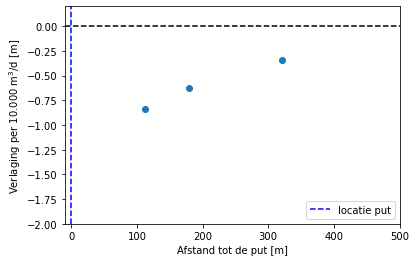

In [13]:
gem_verlaging_1 = ml.get_contribution('onttrekking').mean()
gem_verlaging_2 = ml2.get_contribution('onttrekking').mean()
gem_verlaging_3 = ml3.get_contribution('onttrekking').mean()

gem_onttrekking_1 = well[PB1.index[0] : PB1.index[-1]].mean()
gem_onttrekking_2 = well[PB2.index[0] : PB2.index[-1]].mean()
gem_onttrekking_3 = well[PB3.index[0] : PB3.index[-1]].mean()

gem_verlaging_norm_1 = gem_verlaging_1 / gem_onttrekking_1 * 10000
gem_verlaging_norm_2 = gem_verlaging_2 / gem_onttrekking_2 * 10000
gem_verlaging_norm_3 = gem_verlaging_3 / gem_onttrekking_3 * 10000

dis_1 = 112
dis_2 = 180
dis_3 = 321

fig, ax = plt.subplots()
ax.plot(np.array([dis_1, dis_2, dis_3]),
         np.array([gem_verlaging_norm_1, gem_verlaging_norm_2, gem_verlaging_norm_3]),
        color='C0', marker='o', ls='')
ax.axvline(x=0, ls='--', color='b', label='locatie put')
ax.axhline(y=0, ls='--', color='k', label='')
ax.set_xlim(-10, 500);
ax.set_ylim(-2, 0.2);
ax.set_xlabel('Afstand tot de put [m]')
ax.set_ylabel('Verlaging per 10.000 m$^3$/d [m]')
ax.legend();